# Modeling HUPA0003 using rapid acting insulin and carb_input as exogenous variables 

## Get data and visualize it 

In [184]:
import pandas  as pd 
import matplotlib.pyplot as plt

In [185]:
data = pd.read_csv('../Data/Preprocessed/HUPA0003P.csv', sep=';')
data['time'] = pd.to_datetime(data['time'])

As portions of carbs are equivalent to 10g we convert it back into simple grams again in order to measure ICR 

In [186]:
data['carb_input'] = data['carb_input'] * 10 

Visualize it 

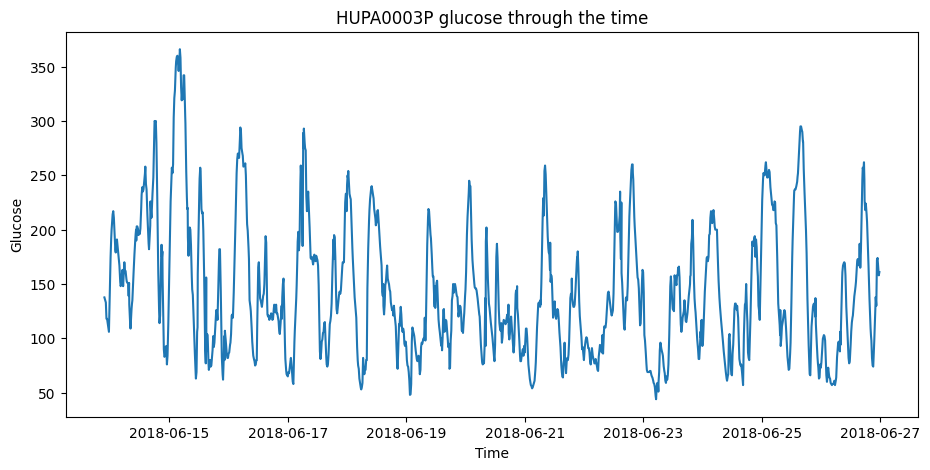

In [187]:
figure, ax = plt.subplots(1,1, figsize=(11, 5))
ax.plot(data['time'], data['glucose'])
ax.set(title='HUPA0003P glucose through the time', xlabel='Time', ylabel='Glucose')
plt.show()

## Insulin to Carb Ratio (ICR)

The ICR represents the number of grams of carbohydrate that 1 unit of rapid-acting insulin will cover. This ratio is highly individualized and varies from person to person.

Formula:
$
ICR = \text{Grams of Carbohydrate Eaten} / \text{Units of Rapid-Acting Insulin Taken}
$

Key Points:
- **Individual variation**: Each person has a unique ICR that may vary throughout the day
- **Clinical importance**: Proper ICR calculation is crucial for effective diabetes management
- **Monitoring**: Regular blood glucose monitoring helps adjust and validate ICR values

This ratio is fundamental for determining insulin dosing for meals and managing postprandial glucose levels.

In [188]:
import seaborn as sns

In [189]:
data.query('carb_input != 0 & bolus_volume_delivered != 0')

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
120,2018-06-14 07:40:00,151.000000,6.52200,72.323529,0.0,0.066667,7.50,75.0
170,2018-06-14 11:50:00,196.000000,11.84830,76.222222,22.0,0.025000,1.75,35.0
203,2018-06-14 14:35:00,240.333333,8.26120,79.142857,6.0,0.066667,5.70,110.0
207,2018-06-14 14:55:00,224.333333,7.06550,88.909091,0.0,0.066667,1.50,20.0
282,2018-06-14 21:10:00,180.000000,14.02230,103.205128,0.0,0.075000,3.20,120.0
...,...,...,...,...,...,...,...,...
3458,2018-06-25 21:50:00,137.000000,11.19348,93.853659,7.0,0.075000,2.50,80.0
3578,2018-06-26 07:50:00,106.000000,8.34024,84.916667,0.0,0.066667,5.70,75.0
3674,2018-06-26 15:50:00,179.666667,7.13310,80.656250,0.0,0.066667,3.70,100.0
3696,2018-06-26 17:40:00,246.000000,17.99736,79.884615,166.0,0.029167,0.35,10.0


In [190]:
indexes = data.query('carb_input != 0 & bolus_volume_delivered != 0').index

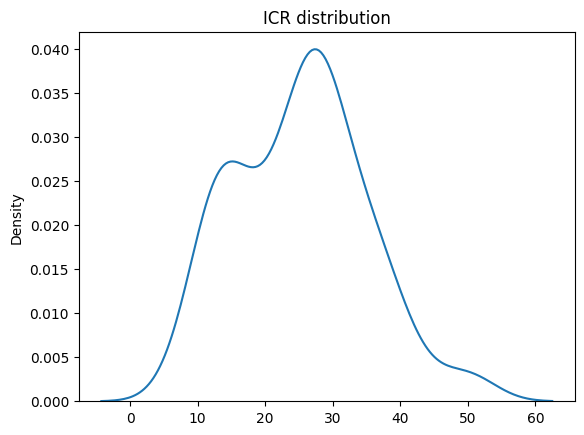

In [191]:
icr = data.loc[indexes]['carb_input'] / data.loc[indexes]['bolus_volume_delivered']
sns.kdeplot(icr)
plt.title('ICR distribution')
plt.show()

Now, let's add ICR as a dataset column

In [192]:
def get_ICR(x):
    carbs = x['carb_input']
    insulin = x['bolus_volume_delivered']
    if carbs == 0:
        return 0 
    elif insulin == 0:
        return 0
    else:
        return carbs/insulin

In [193]:
data['ICR'] = data.apply(get_ICR, axis=1)

In [194]:
data[data['ICR'] != 0]

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,ICR
120,2018-06-14 07:40:00,151.000000,6.52200,72.323529,0.0,0.066667,7.50,75.0,10.000000
170,2018-06-14 11:50:00,196.000000,11.84830,76.222222,22.0,0.025000,1.75,35.0,20.000000
203,2018-06-14 14:35:00,240.333333,8.26120,79.142857,6.0,0.066667,5.70,110.0,19.298246
207,2018-06-14 14:55:00,224.333333,7.06550,88.909091,0.0,0.066667,1.50,20.0,13.333333
282,2018-06-14 21:10:00,180.000000,14.02230,103.205128,0.0,0.075000,3.20,120.0,37.500000
...,...,...,...,...,...,...,...,...,...
3458,2018-06-25 21:50:00,137.000000,11.19348,93.853659,7.0,0.075000,2.50,80.0,32.000000
3578,2018-06-26 07:50:00,106.000000,8.34024,84.916667,0.0,0.066667,5.70,75.0,13.157895
3674,2018-06-26 15:50:00,179.666667,7.13310,80.656250,0.0,0.066667,3.70,100.0,27.027027
3696,2018-06-26 17:40:00,246.000000,17.99736,79.884615,166.0,0.029167,0.35,10.0,28.571429


Let's visualize glucose, carbs, ICR and rapid-acting insulin at the same time, in order to visualize it properly, we normalize it 

In [195]:
def get_ticks(size_window, time_axis):
    index_ticks = []
    j = 0 
    i = 0
    while j != 288: ## A day contains 288 samples
        i = j
        index_ticks.append(time_axis.index[i])
        j += size_window
    ticks = time_axis[index_ticks]
    label_ticks = ticks.dt.strftime('%Y/%m/%d %H:%M')
    return ticks, label_ticks

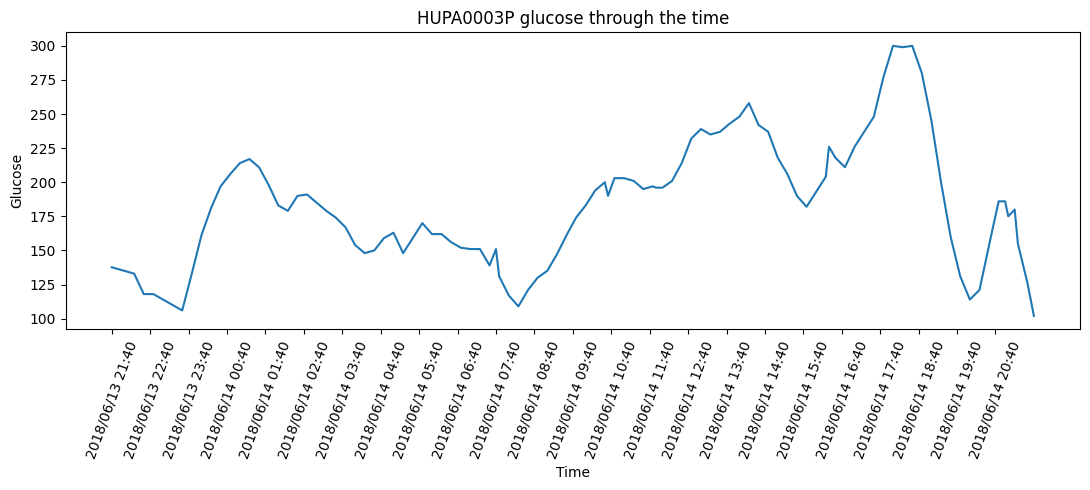

In [196]:
one_day = data[:289]
figure, ax = plt.subplots(1,1, figsize=(11, 5))
ticks, ticks_labels = get_ticks(12, data['time'])
ax.plot(one_day['time'], one_day['glucose'])
ax.set(title='HUPA0003P glucose through the time', xlabel='Time', ylabel='Glucose')
ax.set_xticks(ticks)  
ax.set_xticklabels(ticks_labels, rotation=70)
plt.tight_layout()
plt.show()

In [197]:
def normalize(data):
    mean = data.mean()
    std = data.std()
    if std == 0:
        return data - mean
    return (data - mean) / std

In [198]:
def normalize_df(df):
    return df.select_dtypes(include='float64').apply(normalize, axis=0)

## All variables together 

In [199]:
def plot_variables_normalized(df):
    ## Firstly normalize it and get time_axis 
    time_axis = df['time']
    normalized_df = normalize_df(df)
    ## Now plot it
    _, ax = plt.subplots(1,1, figsize=(11, 7))
    ticks, ticks_labels = get_ticks(12, time_axis)
    for c in normalized_df.columns:
        ax.plot(time_axis, normalized_df[c], label=f'{c}')
    ax.set(title='The behaivor of all variables along one day', xlabel='Time', ylabel='Variables')
    ax.set_xticks(ticks)  
    ax.set_xticklabels(ticks_labels, rotation=70)
    plt.tight_layout()
    plt.legend()
    plt.show()

Firstly, plot all variables 

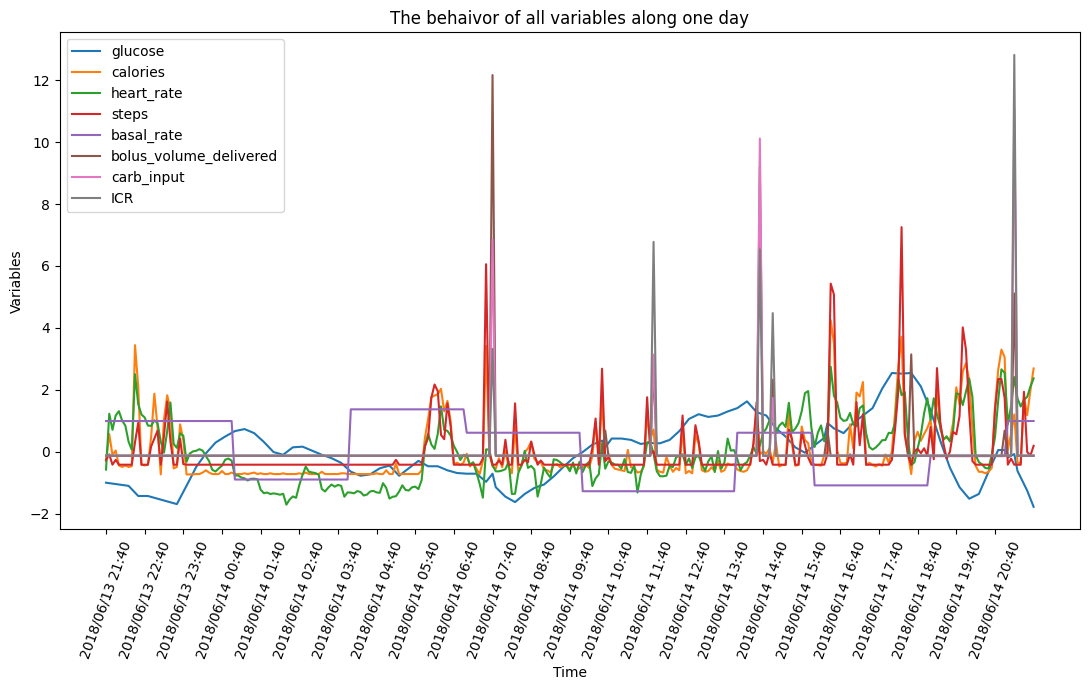

In [200]:
plot_variables_normalized(one_day)

Now just glucose, rapid-acting insulin and steps 

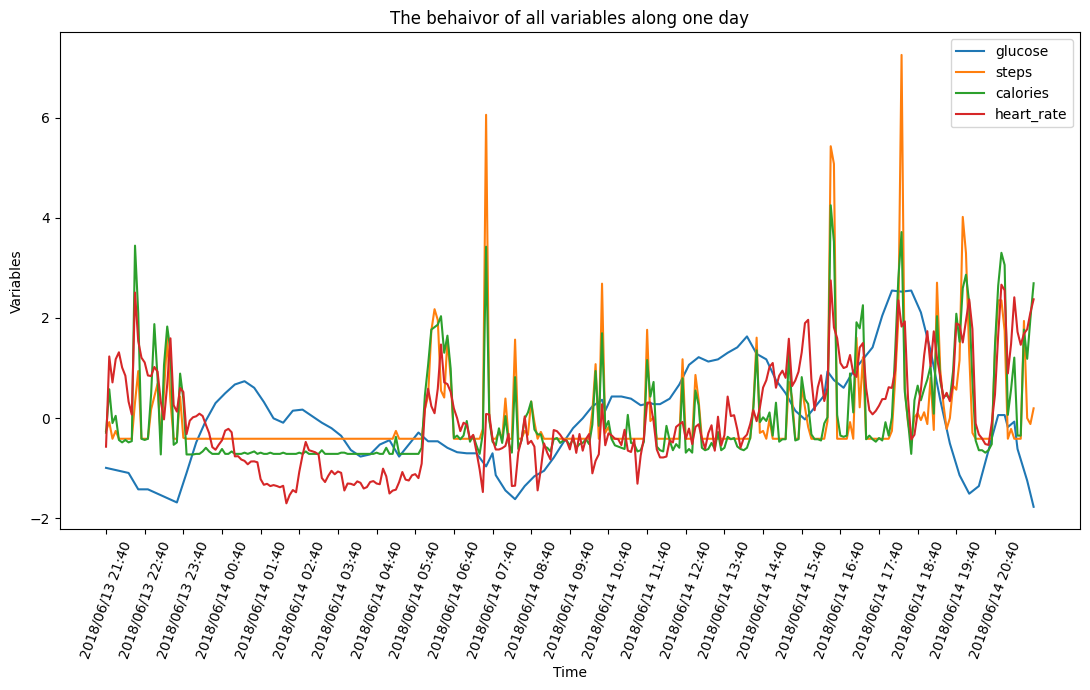

In [201]:
plot_variables_normalized(one_day[['time', 'glucose', 'steps', 'calories', 'heart_rate']])

As we could see above apparently, exists a correspondence between steps and glucose, in order to explore it, let's plot another day 

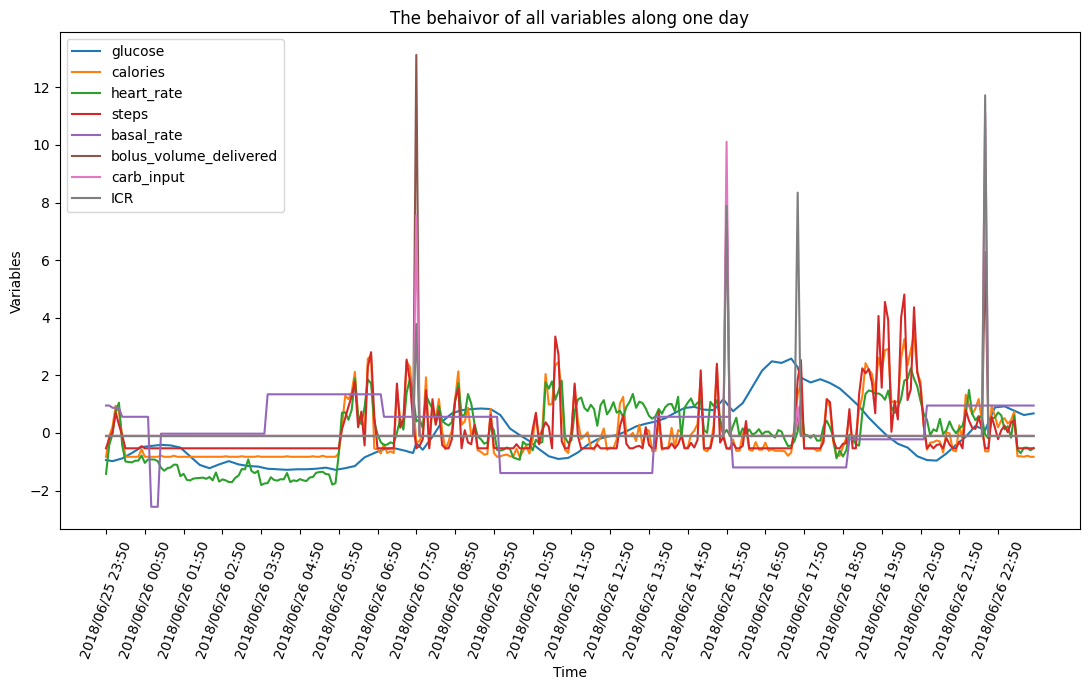

In [202]:
last_day = data[-288:]
plot_variables_normalized(last_day)

## Correlations 

In [203]:
data

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,ICR
0,2018-06-13 21:40:00,137.666667,7.32088,70.692308,8.0,0.075,0.0,0.0,0.0
1,2018-06-13 21:45:00,137.000000,11.19664,90.333333,17.0,0.075,0.0,0.0,0.0
2,2018-06-13 21:50:00,136.333333,8.18216,84.677419,0.0,0.075,0.0,0.0,0.0
3,2018-06-13 21:55:00,135.666667,8.82812,89.727273,8.0,0.075,0.0,0.0,0.0
4,2018-06-13 22:00:00,135.000000,6.67492,91.235294,0.0,0.075,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3765,2018-06-26 23:25:00,160.666667,5.59674,68.875000,0.0,0.075,0.0,0.0,0.0
3766,2018-06-26 23:30:00,158.000000,5.48700,71.621622,0.0,0.075,0.0,0.0,0.0
3767,2018-06-26 23:35:00,159.000000,5.70648,71.692308,0.0,0.075,0.0,0.0,0.0
3768,2018-06-26 23:40:00,160.000000,5.48700,70.346154,0.0,0.075,0.0,0.0,0.0


In [204]:
corr_matrix = data.corr(numeric_only=True)

In [205]:
corr_matrix['glucose']

glucose                   1.000000
calories                 -0.113278
heart_rate               -0.097599
steps                    -0.067376
basal_rate               -0.010351
bolus_volume_delivered    0.026106
carb_input               -0.001757
ICR                      -0.004856
Name: glucose, dtype: float64

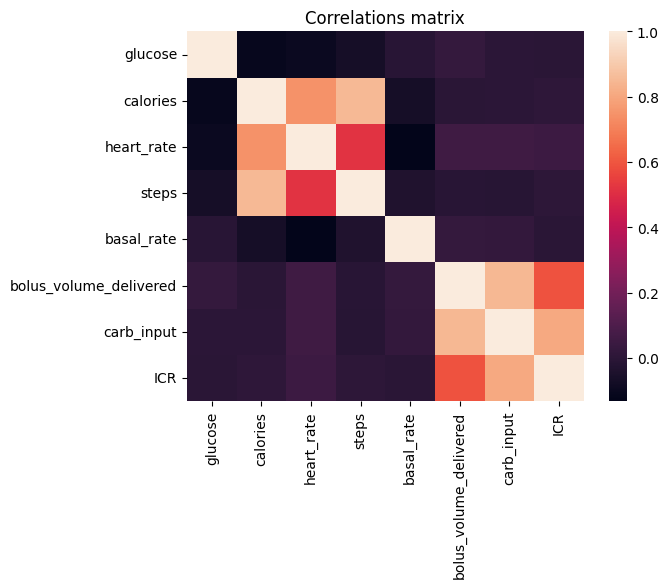

In [206]:
sns.heatmap(corr_matrix)
plt.title('Correlations matrix')
plt.show()

## Define train and test size 

In [207]:
horizon = 6
train, test = data[:-horizon], data[-horizon:]

## AIC and BIC criteria 

Now, we generate all combinations (p=4,q=4) to apply both AIC and BIC

In [208]:
from itertools import product

range_start = 0
range_end = 5
combinations = list(product(range(range_start, range_end), repeat=2))

In [209]:
combinations

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [210]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: pd. Series, exog: pd.Series, order_list: list, d: int) -> pd.DataFrame:
    results = []

    for order in order_list:
        try:
            model = SARIMAX(endog, exog, order=(order [0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            print(f'Mistake during {order}')
            continue
        aic = model.aic
        bic = model.bic
        results.append([order, round(aic, 2), round(bic, 2)])

    result_df = pd.DataFrame (results)
    result_df.columns = ['(p,q)', 'AIC', 'BIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True). reset_index(drop=True)
    result_2_df = result_df.sort_values(by='BIC', ascending=True). reset_index(drop=True)
    return result_df[['(p,q)', 'AIC']], result_2_df[['(p,q)', 'BIC']]

In [211]:
aic, bic = optimize_ARIMA(endog=train['glucose'], exog=train['heart_rate'], order_list=combinations, d=0)

/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/arturo27/

In [212]:
aic

,"(p,q)",AIC
0,"(2, 3)",22293.70
1,"(2, 4)",22294.36
2,"(4, 4)",22296.97
3,"(3, 4)",22297.22
4,"(4, 0)",22305.26
5,"(4, 1)",22308.15
6,"(3, 3)",22356.87
7,"(4, 3)",22370.00
8,"(2, 1)",22379.93
9,"(3, 2)",22382.91


In [213]:
bic

,"(p,q)",BIC
0,"(2, 3)",22337.33
1,"(4, 0)",22342.66
2,"(2, 4)",22344.22
3,"(4, 1)",22351.78
4,"(3, 4)",22353.32
5,"(4, 4)",22359.30
6,"(3, 3)",22406.74
7,"(2, 1)",22411.09
8,"(4, 3)",22426.10
9,"(3, 2)",22426.55


## Residual analysis 

In [214]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np 

In [215]:
best_model = SARIMAX(endog=train['glucose'], exog=train['heart_rate'], order=(2,0,3), simple_differencing=False).fit(disp=False)
residuals = best_model.resid
predictions_train = best_model.fittedvalues

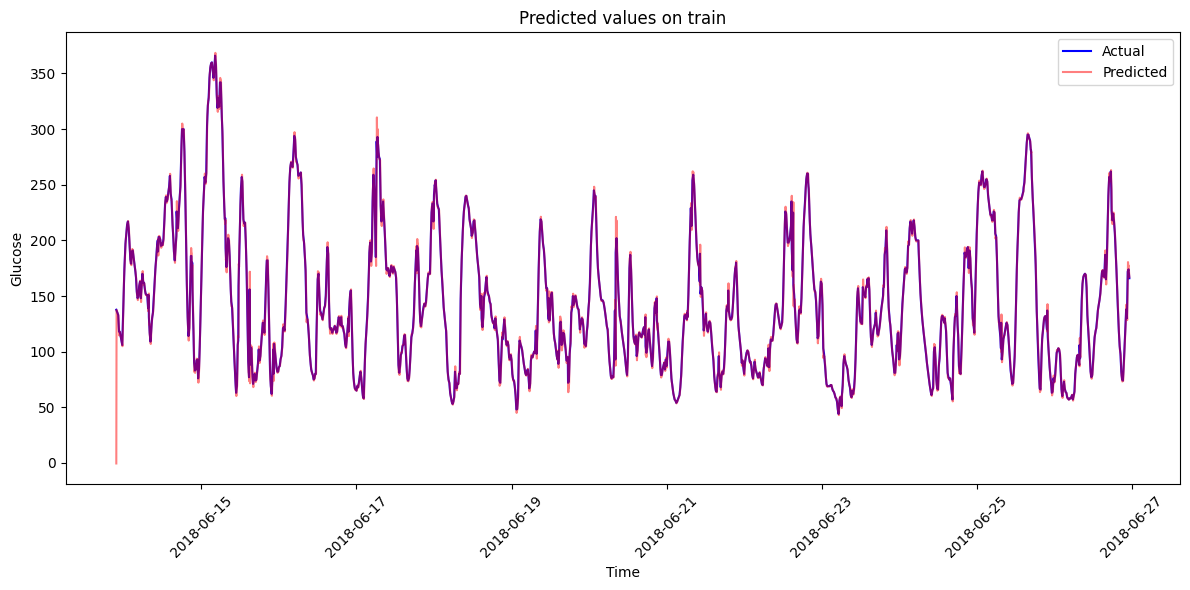

In [216]:
plt.figure(figsize=(12, 6))
plt.plot(train['time'], train['glucose'], label='Actual', color='blue')
plt.plot(train['time'], predictions_train, label='Predicted', color='red', alpha=0.5)
plt.title('Predicted values on train')
plt.xlabel('Time')
plt.ylabel('Glucose')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Qualitative analysis

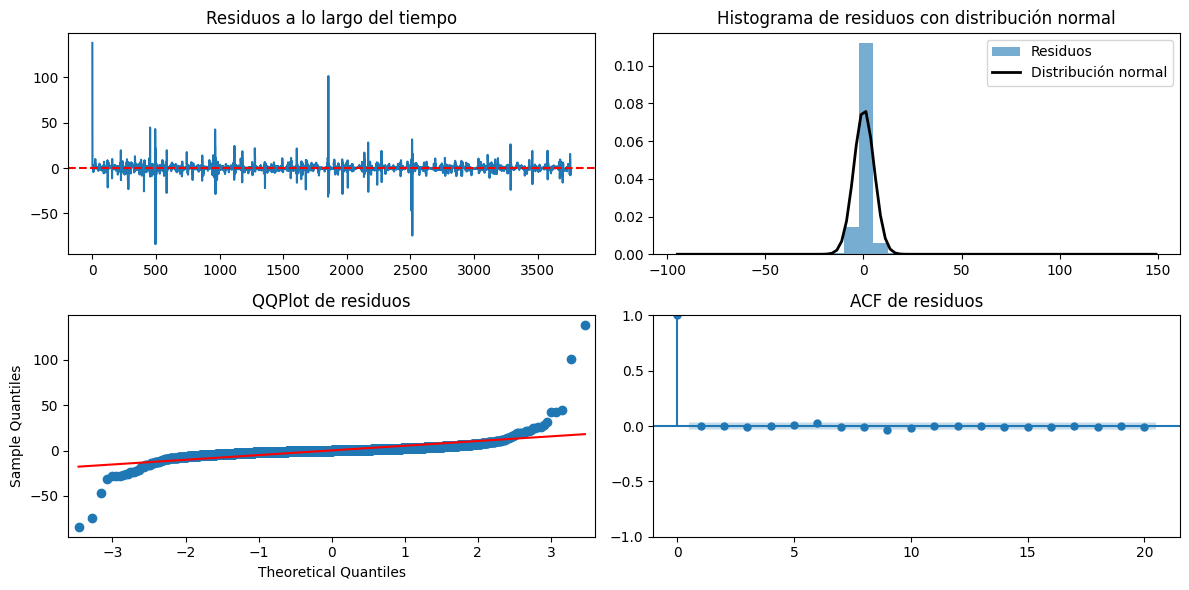

In [217]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.title("Residuos a lo largo del tiempo")
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(2, 2, 2)
plt.hist(residuals, bins=30, density=True, alpha=0.6, label='Residuos')
mu, std = np.mean(residuals), np.std(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Distribución normal')
plt.title("Histograma de residuos con distribución normal")
plt.legend()

plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title("QQPlot de residuos")

plt.subplot(2, 2, 4)
sm.graphics.tsa.plot_acf(residuals, lags=20, alpha=0.05, ax=plt.gca())
plt.title("ACF de residuos")

plt.tight_layout()
plt.show()

### Quantitative analysis 

We Ljung-Box test establish that the residuals are independently distributed as null hypothesis 

In [218]:
lags = np.arange(1, 11, 1)
df_residuals = acorr_ljungbox(residuals, lags)
df_residuals['Lag k'] = np.arange(1, 11)

In [219]:
df_residuals

,lb_stat,lb_pvalue,Lag k
1,0.000465,0.982804,1
2,0.003279,0.998362,2
3,0.115962,0.989855,3
4,0.145668,0.997473,4
5,0.253372,0.998429,5
6,3.459693,0.749324,6
7,3.923854,0.788505,7
8,4.559105,0.803491,8
9,9.573162,0.386131,9
10,10.890789,0.366090,10


## Test

In [220]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                glucose   No. Observations:                 3764
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -11139.850
Date:                Fri, 03 Oct 2025   AIC                          22293.701
Time:                        19:41:07   BIC                          22337.334
Sample:                             0   HQIC                         22309.215
                               - 3764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
heart_rate    -0.0066      0.013     -0.524      0.600      -0.031       0.018
ar.L1          1.8019      0.015    120.474      0.000       1.773       1.831
ar.L2         -0.8028      0.015    -53.672      0.0

In [221]:
test_predicted = best_model.predict(
    start=len(train), 
    end=len(train)+len(test)-1,
    exog=test['heart_rate']
)

Plot predictions 

In [222]:
test['glucose']

3764    163.333333
3765    160.666667
3766    158.000000
3767    159.000000
3768    160.000000
3769    161.000000
Name: glucose, dtype: float64

In [223]:
test_predicted

3764    163.951553
3765    161.920380
3766    159.975890
3767    158.290111
3768    156.808683
3769    155.469122
Name: predicted_mean, dtype: float64

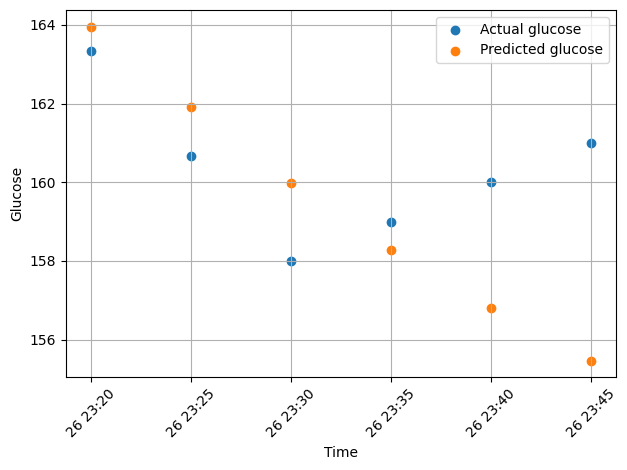

In [226]:
time_test = test['time'][-horizon:]
plt.scatter(time_test, test['glucose'], label='Actual glucose')
plt.scatter(time_test, test_predicted, label='Predicted glucose')
plt.xlabel('Time')
plt.ylabel('Glucose')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.grid()
plt.ticklabel_format()
plt.show()
